# Zadanie domowe 3
## WUM

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split

### Wczytanie danych

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [6]:
data.shape

(647054, 7)

### Brakujące dane

In [7]:
data.isna().sum().sum()

9619

In [8]:
data = data.loc[data.isna().sum(axis=1)==0,:]

### Różne rodzaje tripów

In [9]:
print(np.sort(data.TripType.unique()))
print(data.TripType.unique().shape)

[  3   4   5   6   7   8   9  12  14  15  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44 999]
(38,)


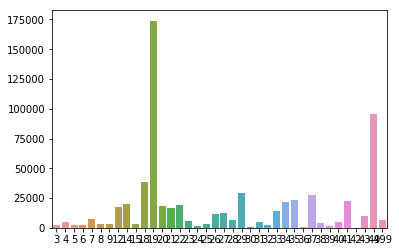

In [10]:
sns.barplot(data.TripType.unique(),data.groupby('TripType').size())
plt.show()

In [11]:
(data.groupby('VisitNumber').nunique().TripType != 1).sum()

0

Dla każdej wizyty w sklepie jest tylko jeden $TripType$

Z początku będziemy rozpatrywac bez VisitNumber, a następnie dla danego VisitNumber wybierzemy modę, bo dany visitnumber ma tylko jeden triptype.

In [12]:
data.groupby('VisitNumber').size().mean()

6.821702547561196

Średnie około 7 zakupów w trakcie jednej wizyty.

In [13]:
np.mean(data.TripType==999)

0.02681183652836645

$2.7 \%$ Tripów 999

### Rozkłady

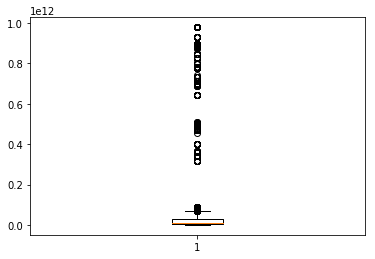

In [14]:
plt.boxplot(data.Upc)
plt.show()

Zlogarytmowanie Upc

In [15]:
data.Upc = np.log(data.Upc)

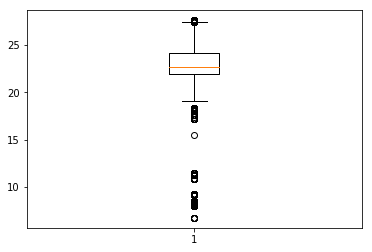

In [16]:
plt.boxplot(data.Upc)
plt.show()

# Encoding

## Ordinal Encoding

Przekodowanie dni tygodnia na kolejne liczby naturalne.

In [17]:
from sklearn.preprocessing import OrdinalEncoder

In [18]:
oe = OrdinalEncoder(categories=[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']])
data.Weekday = oe.fit_transform(data.Weekday.values.reshape((-1,1)))

## One Hot Encoding

In [19]:
data_enc = pd.get_dummies(data, columns=['DepartmentDescription'])

In [20]:
data_enc.shape

(642925, 74)

In [21]:
data_enc.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,999,5,4.0,24.944436,-1,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,7,4.0,24.826551,1,8931.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,30,7,4.0,22.726206,1,4504.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,8,4.0,21.529029,2,3565.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,8,4.0,21.419714,2,1017.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Wykres korelacji

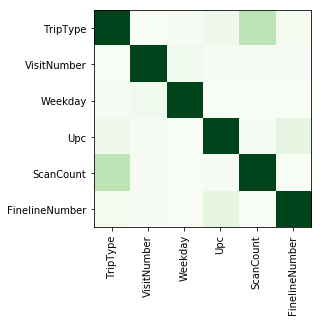

In [22]:
plt.imshow(data_enc.iloc[:,:6].corr().abs(), cmap=plt.cm.Greens)
plt.xticks(np.arange(6),data_enc.iloc[:,:6].columns, rotation=90)
plt.yticks(np.arange(6),data_enc.iloc[:,:6].columns)
plt.show()

In [23]:
data_enc.isna().sum().sum()

0

In [24]:
data_enc.shape

(642925, 74)

### Funkcja do testowania

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
def test(data, classifier, departments=False):
    
    if departments:
        X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['TripType','VisitNumber']), data.TripType)
    else:
        X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['TripType','DepartmentDescription','VisitNumber']), data.TripType)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print(accuracy_score(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.show()

### Test:
### +ordinal encoding
### +one hot encoding (z departments)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data_enc.drop(columns=['TripType', 'VisitNumber']), data_enc.TripType)

In [28]:
RFC = RandomForestClassifier(1000, max_depth=3, n_jobs=2)
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
y_pred = RFC.predict(X_test)

#### Accuracy

In [30]:
accuracy_score(y_test, y_pred)

0.28100191623323295

#### Macierz pomyłek

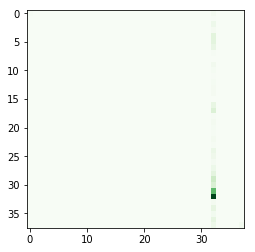

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.show()

### Test:
### +ordinal encoding
### -one hot encoding (bez departments)

In [32]:
data2 = data

In [33]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2.drop(columns=['TripType','DepartmentDescription','VisitNumber']), data2.TripType)

In [34]:
RFC2 = RandomForestClassifier(1000, max_depth=3, n_jobs=2)
RFC2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
y_pred2 = RFC2.predict(X_test2)

#### Accuracy

In [36]:
accuracy_score(y_test2, y_pred2)

0.2912736729462708

In [37]:
data.columns[RFC2.feature_importances_.argsort()]

Index(['TripType', 'Upc', 'VisitNumber', 'Weekday'], dtype='object')

#### Macierz pomyłek

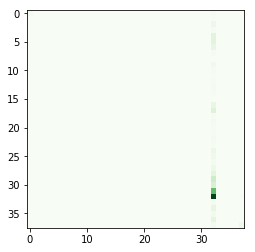

In [38]:
cm = confusion_matrix(y_test2, y_pred2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.show()

### Model lepiej sobie radzi bez departments

# Feature engineering

### Dodanie weekendu

In [39]:
data['weekend'] = (data.Weekday == 5) | (data.Weekday == 6)

0.28782072020506183


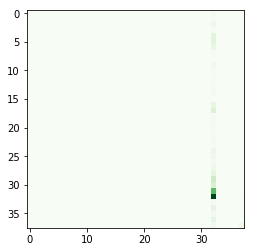

In [40]:
test(data, RandomForestClassifier(1000, max_depth=3, n_jobs=2))

### Kategoryzacja Upc

In [41]:
bins = pd.cut(data.Upc,bins=20, labels=np.arange(20), include_lowest=True)
bins = bins.astype(int)

In [42]:
data.Upc = bins

0.2847037304332678


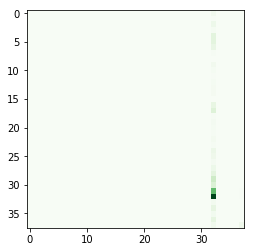

In [43]:
test(data, RandomForestClassifier(1000, max_depth=3, n_jobs=2))

### Przenumerowanie DepartmentDescription względem liczności

In [44]:
data.groupby('TripType').DepartmentDescription.agg(lambda x: x.mode())

TripType
3                        FINANCIAL SERVICES
4                              PHARMACY OTC
5                              PHARMACY OTC
6                          LIQUOR,WINE,BEER
7                              SERVICE DELI
8                               DSD GROCERY
9                                 MENS WEAR
12     [DSD GROCERY, HOUSEHOLD PAPER GOODS]
14                       FABRICS AND CRAFTS
15                              CELEBRATION
18                                     TOYS
19                              ELECTRONICS
20                               AUTOMOTIVE
21                       FABRICS AND CRAFTS
22                              ELECTRONICS
23                  PLAYERS AND ELECTRONICS
24                            COOK AND DINE
25                                MENS WEAR
26                                 HARDWARE
27                          LAWN AND GARDEN
28                           SPORTING GOODS
29                                     TOYS
30                     

In [45]:
dep = data.groupby('DepartmentDescription').size().sort_values().index
dict = dict([(key, i) for i,key in enumerate(dep)])

In [46]:
data.DepartmentDescription = data.DepartmentDescription.map(dict)

0.2863275514521066


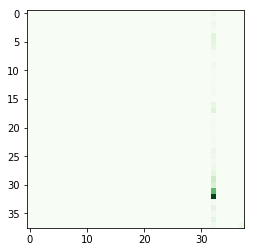

In [47]:
test(data, RandomForestClassifier(1000, max_depth=3, n_jobs=2), True)

# Podsumowanie

* Dodanie nowych cech jest w stanie nieznacznie poprawić działanie modelu.
* Mimo wszystko model, z uwagi na duże zróżnicowanie klas, skupia sie po prostu na klasyfikowaniu jednej klasy.
* W tym wypadku one hot encoding na departments pogarsza wynik, z uwagi na wiele unikatowych wartości
* Przenumerowanie dni tygodnia poprawia działanie modelu.